## Coupled two-particle harmonic oscillator (1D) with DMC

We solve the 1D coupled two-particle system with

$$
V(x_1, x_2) = \frac{1}{2}\omega^2 (x_1^2 + x_2^2) + \frac{1}{2}\kappa (x_1 - x_2)^2,
$$

using diffusion Monte Carlo and report the ground-state energy.

In [1]:
using Pkg

Pkg.activate("/Users/ismaelchona/PersonalProjects/DMC_project")
Pkg.instantiate()

using System1D
using Random
using Statistics
using KernelDensity
using Plots

figdir = joinpath("/Users/ismaelchona/PersonalProjects/DMC_project/Notebooks", "figures")
mkpath(figdir)

  Activating project at `~/PersonalProjects/DMC_project`


"/Users/ismaelchona/PersonalProjects/DMC_project/Notebooks/figures"

## System setup and trial wavefunction

We use atomic units with $D=0.5$ (so $m=1$, $\hbar=1$).

In [2]:
omega = 1.0
kappa = 0.7

V = R -> begin
    x1, x2 = R
    0.5 * omega^2 * (x1^2 + x2^2) + 0.5 * kappa * (x1 - x2)^2
end

H = Hamiltonian(2, 0.5, V)

omega_rel = sqrt(omega^2 + 2 * kappa)
E_ref = 0.5 * (omega + omega_rel)

# Exact Gaussian ground-state trial wavefunction in normal-mode form.
function logpsi(R)
    x1, x2 = R
    S = x1 + x2
    D = x1 - x2
    return -0.25 * omega * S^2 - 0.25 * omega_rel * D^2
end

function gradlogpsi(R)
    x1, x2 = R
    S = x1 + x2
    D = x1 - x2
    return [-0.5 * (omega * S + omega_rel * D),
            -0.5 * (omega * S - omega_rel * D)]
end

lapllogpsi(R) = -(omega + omega_rel)

trial = System1D.TrialWF(logpsi, gradlogpsi, lapllogpsi)
guiding = System1D.ImportanceGuiding(trial, H)

# DMC parameters.
params = DMCParams(0.005, 2000, 500, 5_000, E_ref, 0.0, 25, 100)

DMCParams(0.005, 2000, 500, 5000, 1.2745966692414834, 0.0, 25, 100)

## Run the simulation

In [3]:
selected_taus = [0.0, 0.5, 1.0, 2.0]
snapshot_steps = unique([round(Int, tau / params.dt) for tau in selected_taus])
0 in snapshot_steps || push!(snapshot_steps, 0)
snapshot_steps = sort(snapshot_steps)

seed = 1234
rng_init = MersenneTwister(seed)
rng_sim = MersenneTwister(seed + 1)
walkers = [Walker(2 .* rand(rng_init, 2) .- 1) for _ in 1:params.targetN]

sim = DMCSim(H, params, walkers, rng_sim; guiding=guiding, nodepolicy=System1D.NoNode())

# Only store snapshots at selected steps to save memory.
sim = System1D.run_simulation!(sim; snapshot_steps=snapshot_steps)

ET = sim.ET_history
pop = sim.population_history
energy = sim.energy_mean_history

snaps = Dict(step => sim.walker_positions_history[i] for (i, step) in enumerate(snapshot_steps))

tau = (0:params.nsteps) .* params.dt

0.0:0.005:10.0

## Diagnostics and plots

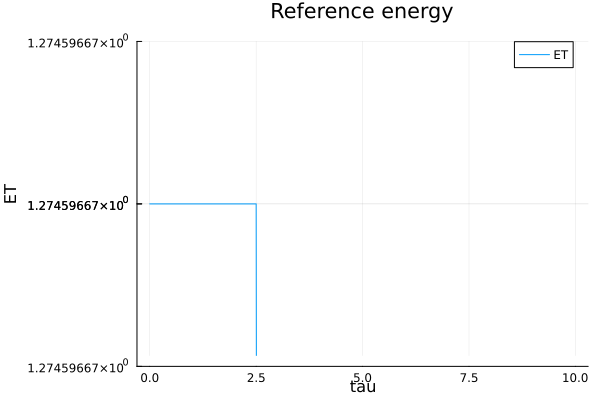

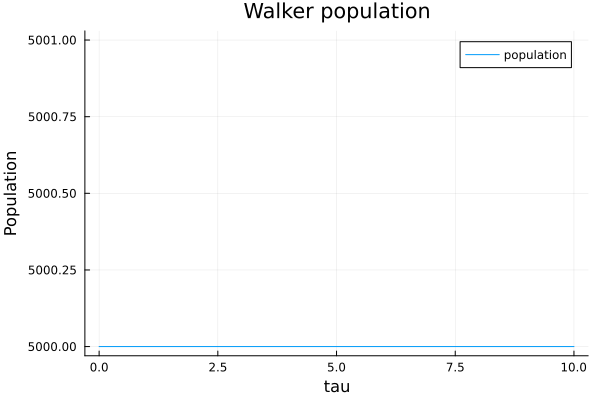

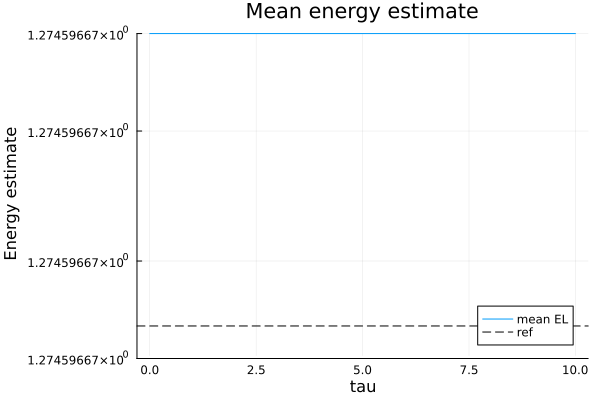

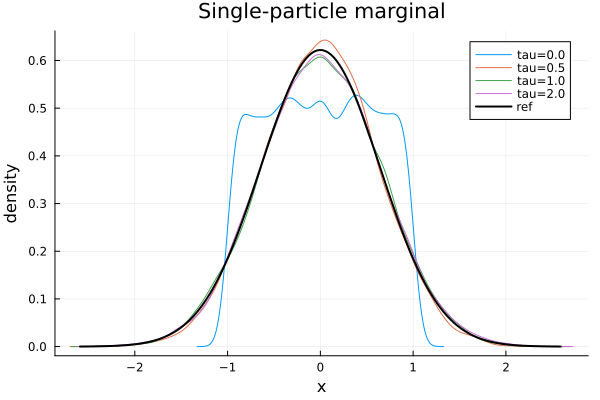

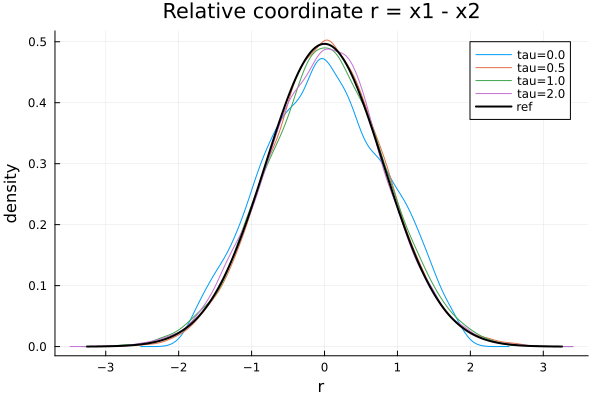

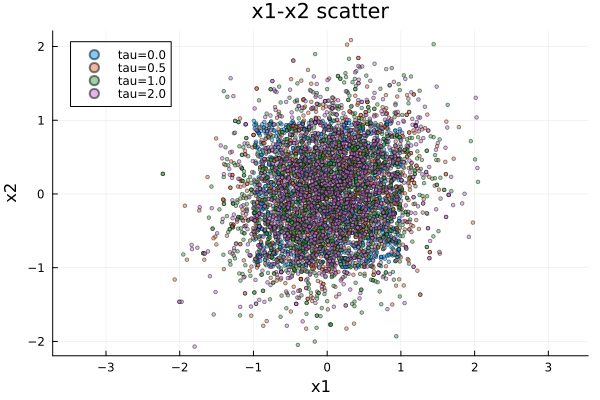

GKS: Possible loss of precision in routine SET_WINDOW


In [4]:
plt_ET = plot(tau, ET; label="ET", xlabel="tau", ylabel="ET", title="Reference energy")
savefig(plt_ET, joinpath(figdir, "coupling_ET_vs_tau.png"))
display(plt_ET)

plt_pop = plot(tau, pop; label="population", xlabel="tau", ylabel="Population", title="Walker population")
savefig(plt_pop, joinpath(figdir, "coupling_population_vs_tau.png"))
display(plt_pop)

plt_E = plot(tau, energy; label="mean EL", xlabel="tau", ylabel="Energy estimate", title="Mean energy estimate")
hline!(plt_E, [E_ref]; label="ref", linestyle=:dash, color=:black)
savefig(plt_E, joinpath(figdir, "coupling_energy_vs_tau.png"))
display(plt_E)

# Build reference grids from the last snapshot.
last_snap = snaps[snapshot_steps[end]]
xs_ref = Float64[]
for R in last_snap
    append!(xs_ref, R)
end
xmax = maximum(abs.(xs_ref))
xgrid = range(-1.1 * xmax, 1.1 * xmax, length=400)

sigma2 = (omega + omega_rel) / (4 * omega * omega_rel)
rho1_ref(x) = (1 / sqrt(2 * pi * sigma2)) * exp(-x^2 / (2 * sigma2))

rvals_ref = [R[1] - R[2] for R in last_snap]
rmax = maximum(abs.(rvals_ref))
rgrid = range(-1.1 * rmax, 1.1 * rmax, length=400)
rel_ref(r) = sqrt(omega_rel / (2 * pi)) * exp(-0.5 * omega_rel * r^2)

function collect_coords(snapshot)
    xs = Float64[]
    for R in snapshot
        append!(xs, R)
    end
    return xs
end

plt_marg = plot(; xlabel="x", ylabel="density", title="Single-particle marginal")
for s in snapshot_steps
    xs = collect_coords(snaps[s])
    kd = kde(xs)
    plot!(plt_marg, kd.x, kd.density; label="tau=$(round(s * params.dt, digits=2))")
end
plot!(plt_marg, xgrid, rho1_ref.(xgrid); label="ref", linewidth=2, color=:black)
savefig(plt_marg, joinpath(figdir, "coupling_marginal_kde_vs_tau.png"))
display(plt_marg)

plt_rel = plot(; xlabel="r", ylabel="density", title="Relative coordinate r = x1 - x2")
for s in snapshot_steps
    rvals = [R[1] - R[2] for R in snaps[s]]
    kd = kde(rvals)
    plot!(plt_rel, kd.x, kd.density; label="tau=$(round(s * params.dt, digits=2))")
end
plot!(plt_rel, rgrid, rel_ref.(rgrid); label="ref", linewidth=2, color=:black)
savefig(plt_rel, joinpath(figdir, "coupling_relative_kde_vs_tau.png"))
display(plt_rel)

function scatter_snapshots(snaps, steps)
    plt = plot(; xlabel="x1", ylabel="x2", title="x1-x2 scatter", aspect_ratio=:equal)
    rng = MersenneTwister(2025)
    for s in steps
        snap = snaps[s]
        n = min(length(snap), 1500)
        idx = rand(rng, 1:length(snap), n)
        xs = [snap[i][1] for i in idx]
        ys = [snap[i][2] for i in idx]
        scatter!(plt, xs, ys; label="tau=$(round(s * params.dt, digits=2))", markersize=2, alpha=0.5)
    end
    return plt
end

plt_scatter = scatter_snapshots(snaps, snapshot_steps)
savefig(plt_scatter, joinpath(figdir, "coupling_scatter_x1_x2.png"))
display(plt_scatter)

## Energy estimate

In [5]:
start_idx = params.nequil + 2
E_mean = mean(energy[start_idx:end])
E_sem = std(energy[start_idx:end]) / sqrt(length(energy[start_idx:end]))
println("Coupled HO mean energy (after equil): $(round(E_mean, digits=4)) +/- $(round(E_sem, digits=4))")
println("Reference ground-state energy: $(round(E_ref, digits=6))")

Coupled HO mean energy (after equil): 1.2746 +/- 0.0
Reference ground-state energy: 1.274597
